In [1]:
chan_index = int(input('Enter channel index to analyze:'))
# print('Enter Open Ephys data directory path:')
# source_path = raw_input()

Enter channel index to analyze:2


In [2]:
source_path = '../data/OpenEphys_data/2019-04-11_13-02-56'

In [3]:
import time
t0 = time.time()
import OpenEphys
from kaveh.toolbox import common_avg_ref, butter_bandpass_filter
import Kwik
from matplotlib import pyplot as plt
import numpy as np
import os
import re
import scipy.signal

In [4]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [5]:
f_names = []
for root, dirnames, filenames in os.walk(source_path):
    for filename in filenames:
        f_regex = re.compile(r".*CH(\d|\d\d)\.continuous$")
        if f_regex.match(filename):
            f_names = f_names + [os.path.join(root, filename)]
f_names = np.array(f_names)
chans = [int(f.split('.')[-2].split('_')[-1][2:]) for f in f_names]
f_names = f_names[np.argsort(chans)] # now sorted by channel number

In [7]:
chan_data = []
for contact in range(7):
    contact_reps = []
    for i in range(contact*4, contact*4 + 4):
        print('Reading {}...'.format(f_names[i]))
        file_content = OpenEphys.load(f_names[i])
        Fs = float(file_content['header']['sampleRate'])
        signal_filtered = butter_bandpass_filter(file_content['data'], 200, 3000, Fs, order=2 )
        contact_reps.append(signal_filtered)
    contact_reps = np.array(contact_reps)
    chan_data.append(np.mean(contact_reps, axis=0))
    print('-----------------------------------------------')
chan_data = np.array(chan_data)
contact_reps = None

Reading ../data/OpenEphys_data/2019-04-11_13-02-56/102_CH1.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-11_13-02-56/102_CH2.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-11_13-02-56/102_CH3.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-11_13-02-56/102_CH4.continuous...
Loading continuous data...
-----------------------------------------------
Reading ../data/OpenEphys_data/2019-04-11_13-02-56/102_CH5.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-11_13-02-56/102_CH6.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-11_13-02-56/102_CH7.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-04-11_13-02-56/102_CH8.continuous...
Loading continuous data...
-----------------------------------------------
Reading ../data/OpenEphys_data/2019-04-11_13-02-56/102_CH9.continuous...
Loading continuous data...
Read

In [8]:
common_avg_ref(chan_data)
chan_data = scipy.signal.detrend(chan_data)

chan_filtered_fname = os.path.join(source_path, 'channels_filtered.npy')
print('Saving filtered data to {}'.format(chan_filtered_fname))
np.save(chan_filtered_fname, chan_data)

Saving filtered data to ../data/OpenEphys_data/2019-04-11_13-02-56/channels_filtered.npy


In [6]:
chan_filtered_fname = os.path.join(source_path, 'channels_filtered.npy')
chan_data = np.load(chan_filtered_fname)
Fs = 30000.0

### Plot channel voltage

In [35]:
chan_index = int(input('Enter channel index to analyze:'))
# print('Enter Open Ephys data directory path:')
# source_path = raw_input()

Enter channel index to analyze:0


<IPython.core.display.Javascript object>


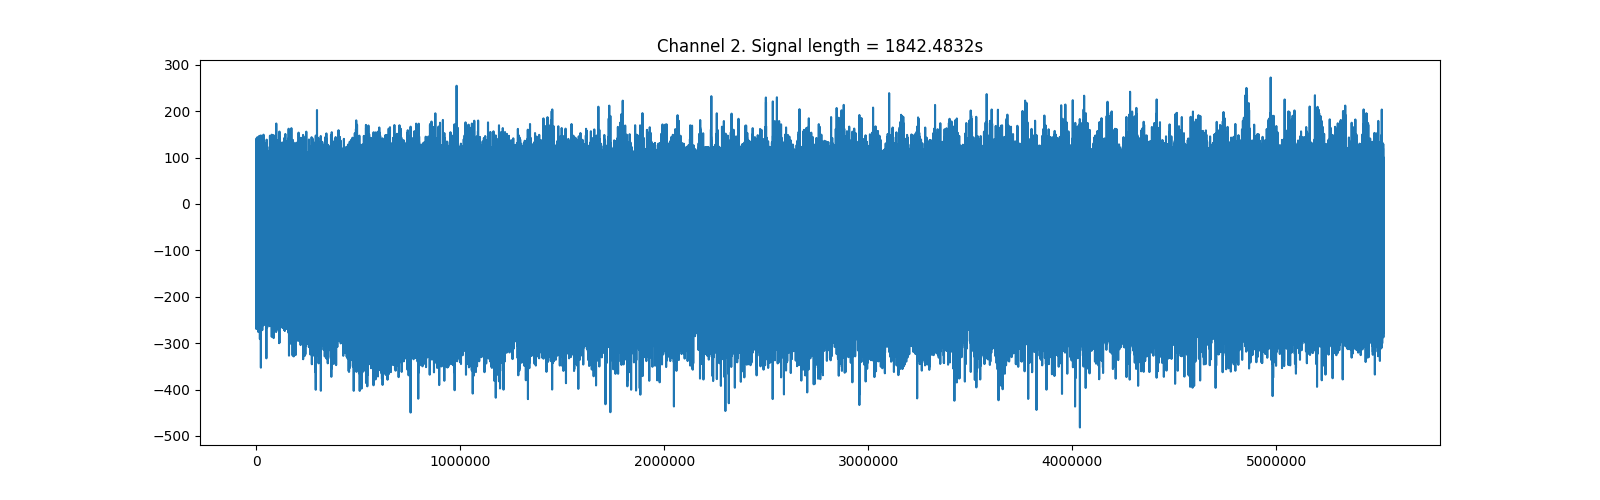

Text(0.5, 1.0, 'Channel 2. Signal length = 1842.4832s')

In [9]:
# plot channel
plt.figure(figsize=(16,5))
plt.plot(chan_data[chan_index,::10])
plt.title('Channel {}. Signal length = {}s'.format(chan_index, chan_data.shape[1]/Fs))

In [ ]:
from cssorter.spikesorter import ComplexSpikeSorter
dt = 1.0/Fs
css = ComplexSpikeSorter(chan_data[chan_index, :], dt)
css.num_gmm_components = 5
css.cs_num_gmm_components = 5
css.pre_window = 0.0001
css.post_window = 0.0015
css.run(use_filtered=False, remove_overlap=False, spike_detection_dir = 'min', align_spikes_to='min')

Pre-process time = 0.6750373840332031
Using minibatch spike detection, batch size = 50s, using filter (derivative) is False
Usinf spikes min for detection. Aligning them to their min. 
Spike detection time = 72.06273531913757
Using all spikes for alignment (no overlap removal)
Align spikes time = 72.57084274291992
Clustering complex spikes...
Splitting detected spikes for CS clustering ...


In [ ]:
css.cs_indices.shape

In [25]:

css._align_spikes(remove_align_overlaps=False)

Using all spikes for alignment (no overlap removal)


In [27]:
css.cs_num_gmm_components = 8
css._detect_cs_minibatch(remove_overlaps=False)

Clustering complex spikes...
Splitting detected spikes for CS clustering ...


/usr/local/lib/python3.6/dist-packages/sklearn/mixture/gaussian_mixture.py:366: RuntimeWarning: divide by zero encountered in log
  n_components, -1)[:, ::n_features + 1]), 1))
/usr/local/lib/python3.6/dist-packages/sklearn/mixture/gaussian_mixture.py:366: RuntimeWarning: invalid value encountered in log
  n_components, -1)[:, ::n_features + 1]), 1))


ValueError: shapes (19776,4) and (15,15) not aligned: 4 (dim 1) != 15 (dim 0)

In [ ]:
css.cs_indices.shape

In [104]:
csiss = np.diff(css.cs_indices)
new_cs = np.delete(css.cs_indices, np.where(csiss < 0.010/css.dt)[0]+1)
print(new_cs.shape)

(376,)


In [102]:
np.where(csiss < 0.010/css.dt)

(array([ 27,  50, 261, 281, 347]),)

In [7]:
from cssorter.spikesorter import ComplexSpikeSorter
dt = 1.0/Fs
css = ComplexSpikeSorter(chan_data[chan_index, :], dt)
css.num_gmm_components = 3
css._init_gmm()
css._pre_process()
css._detect_spikes_minibatch(use_filtered=False, select_clust = 'min', align_to='min')
# print(css.cs_indices.shape)

Using minibatch spike detection, batch size = 50s
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not derivative
Using voltage, not d

In [8]:
css._align_spikes(remove_align_overlaps=False)

Using all spikes for alignment (no overlap removal)


In [14]:
css._detect_cs_minibatch()

[autoreload of cssorter.spikesorter failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/usr/local/lib/python3.6/dist-packages/IPyt

Splitting detected spikes for CS clustering ...


In [15]:
css.cs_indices.shape

(3019,)

In [40]:
a = np.array([1,2,3,4])
a[np.arange(0,a.size)]

array([1, 2, 3, 4])

In [16]:
css.get_spike_indices(remove_overlaps=False)[slice_indices[0]]

array([107, 341, 597, ..., 7197582, 7198403, 7198820], dtype=object)

In [ ]:
css.cs_indices.shape

In [49]:
[_,powers,_] = css._find_max_powers()

In [13]:

delta = int(240/css.dt)
if css.signal_size > 360.0/css.dt:
    print('Splitting signal for CS clustering ...')
    slice_indices = []    
    countall = 0
    for i in np.arange(0, css.signal_size, delta):
        slice_indices.append(np.where(np.logical_and(css.spike_indices >= i ,  css.spike_indices < i + delta))[0])
    if slice_indices[-1].size <= 120/css.dt:
        slice_indices[-2] = np.concatenate((slice_indices[-2], slice_indices[-1]))
        del slice_indices[-1]
print([si.size for si in slice_indices ])
print(sum([si.size for si in slice_indices ]), css.spike_indices.size)

Splitting signal for CS clustering ...
[11283, 11217, 10913, 11195, 11599, 11934, 12518, 12725, 12637, 21934]
127955 127955


In [22]:
slice_indices = []

In [23]:
if not slice_indices:
    print('hola')

hola


In [97]:
powers[slice_indices[0]].shape

(11283, 15)

<IPython.core.display.Javascript object>


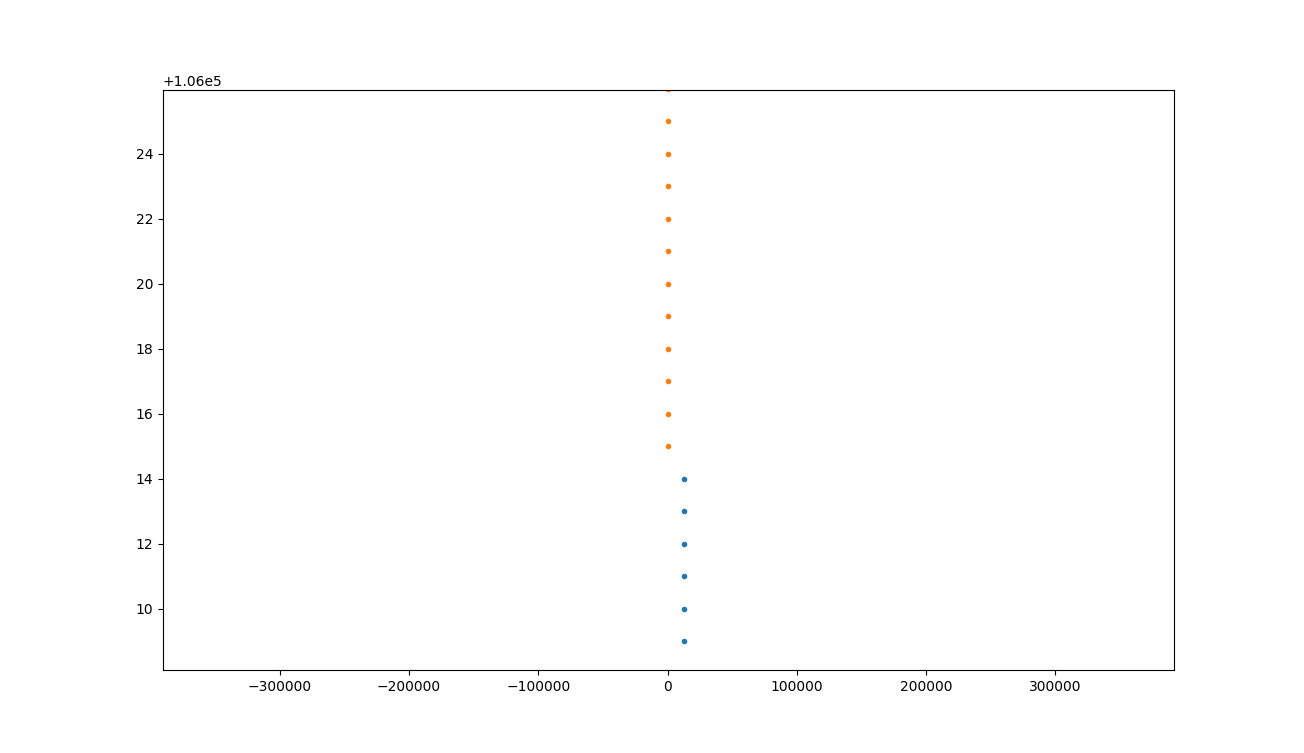

In [93]:
plt.figure()
plt.plot(slice_indices[-2], '.')
plt.plot(slice_indices[-1], '.')


In [69]:
css.spike_indices[-1]*css.dt

2574.0443333333333

In [51]:
css.aligned_spikes.shape

(127949, 144)

In [23]:
# css.run(use_filtered=False)
# print(css.cs_indices.shape)

css._cluster_spike_by_feature(remove_overlaps=False)

css.cs_indices.shape

Using all spikes for alignment (no overlap removal)


(3011,)

In [24]:
orig_cs_idnices = css.cs_indices
css.cs_indices = css._remove_overlapping_complex_spikes()


Merging overlapping CS waveforms


(2388,)

In [40]:
css.cs_indices = orig_cs_idnices

In [92]:
css._realign_complex_spikes()

[autoreload of cssorter.spikesorter failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/usr/local/lib/python3.6/dist-packages/IPyt

In [30]:
num_clusters = 6
pre_time = 0.001
post_time = 0.003
print(css.cs_indices.shape)
clusters, cluster_labels = css.cluster_detected_cs(num_clusters=num_clusters, pre_time=pre_time, post_time=post_time, align_to='min')

ss_indices = css.get_ss_indices()

(6429,)


In [31]:
ss_indices.shape

(221087,)

In [32]:
import random
pre_index = int(np.round(pre_time/css.dt))
post_index = int(np.round(post_time/css.dt))
aligned_ss = np.array([css.voltage[i - pre_index : i + post_index] for i in ss_indices[1:-2]])
mean_ss = np.mean(aligned_ss[random.sample(range(0, aligned_ss.shape[0]), css.cs_indices.size), ], axis=0)

In [33]:
t1 = time.time()
print('Total run time = {} s'.format(t1-t0))

Total run time = 1232.2856743335724 s


<IPython.core.display.Javascript object>


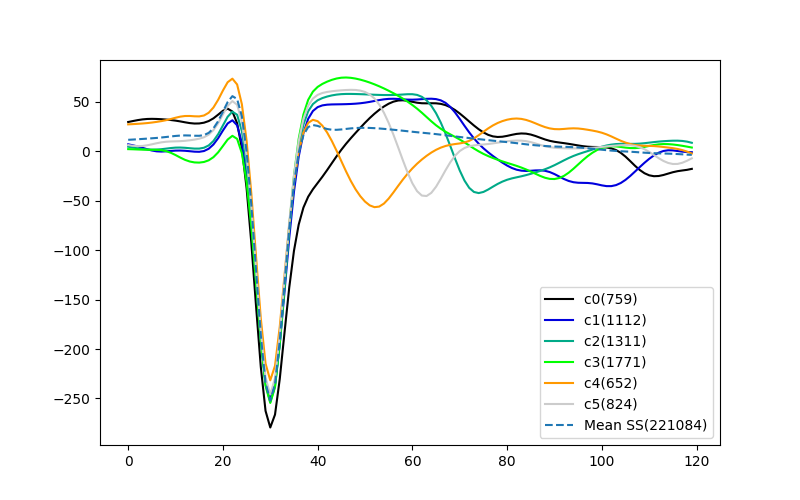

In [34]:
# plot cluster means
colors = plt.cm.nipy_spectral(np.linspace(0,1,num_clusters))
legend_labels = []
for cn in np.arange(num_clusters):
    legend_labels.append('c{}({}) '.format(cn, clusters[cn].shape[0]))

import gc
gc.collect()
plt.figure(figsize=(8,5))
clust_means = []
paxes = []
for cn in np.arange(num_clusters):
    clust_means.append(np.mean(clusters[cn], axis=0))
    ax = plt.plot(clust_means[-1], color = colors[cn], label = legend_labels[cn])
    paxes.append(ax)
plt.plot(mean_ss, '--', label = 'Mean SS({})'.format(aligned_ss.shape[0]))
plt.legend() 

In [56]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(clust_means)
cs_clust = np.argmax(np.sum(np.abs(kmeans.cluster_centers_), axis=1))
clusters_to_pick = np.where(kmeans.labels_ == cs_clust)[0]
print('Detected CS clusters: {}'.format(clusters_to_pick))

Detected CS clusters: [ 4  7  9 11]


In [36]:
ans = input("Enter CS clusters (comma separated; example: 5,3,1). Type a character to accept the detected cluster: ")
ans_regex = re.compile(r'\d+(?:,\d+)?')
if ans_regex.match(ans):
    clusters_to_pick = [int(c) for c in ans.split(',')]
    

[autoreload of cssorter.spikesorter failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/usr/local/lib/python3.6/dist-packages/IPyt

Enter CS clusters (comma separated; example: 5,3,1). Type a character to accept the detected cluster: 3


In [37]:
cs_indices_to_pick = []
for cti in clusters_to_pick:
    cs_indices_to_pick = np.union1d(cs_indices_to_pick, css.cs_indices[np.where(cluster_labels == cti)])
cs_indices = cs_indices_to_pick.astype(np.int64)
print('Number of detected CS: {}'.format(cs_indices.shape))

Number of detected CS: (1771,)


In [72]:
csiss = np.diff(cs_indices)
cs_indices = np.delete(cs_indices, np.where(csiss < 0.005/css.dt)[0] + 1)


In [73]:
cs_indices.shape

(495,)

## Saving detected CS and SS:

In [ ]:
CS_csv_filename = os.path.join(source_path, 'channel_{}.CS.csv'.format(chan_index))
SS_csv_filename = os.path.join(source_path, 'channel_{}.SS.csv'.format(chan_index))

import csv
with open(CS_csv_filename, 'w+') as f:
    print('writing {} ... '.format(CS_csv_filename))
    f.seek(0)
    csvwriter = csv.writer(f, delimiter = ',')
    csvwriter.writerows(cs_indices.reshape(-1,1))
    
with open(SS_csv_filename, 'w+') as f:
    print('writing {} ... '.format(SS_csv_filename))
    f.seek(0)
    csvwriter = csv.writer(f, delimiter = ',')
    csvwriter.writerows(ss_indices.reshape(-1,1))

In [179]:
from scipy.io import loadmat
data = loadmat('../data/OpenEphys_data/2019-04-15_16-07-46/101_CH1_sorted_ehsan.mat')
cs_indices_ehsan = np.squeeze(data['CS_data']['CS_ind'][0][0])

<IPython.core.display.Javascript object>


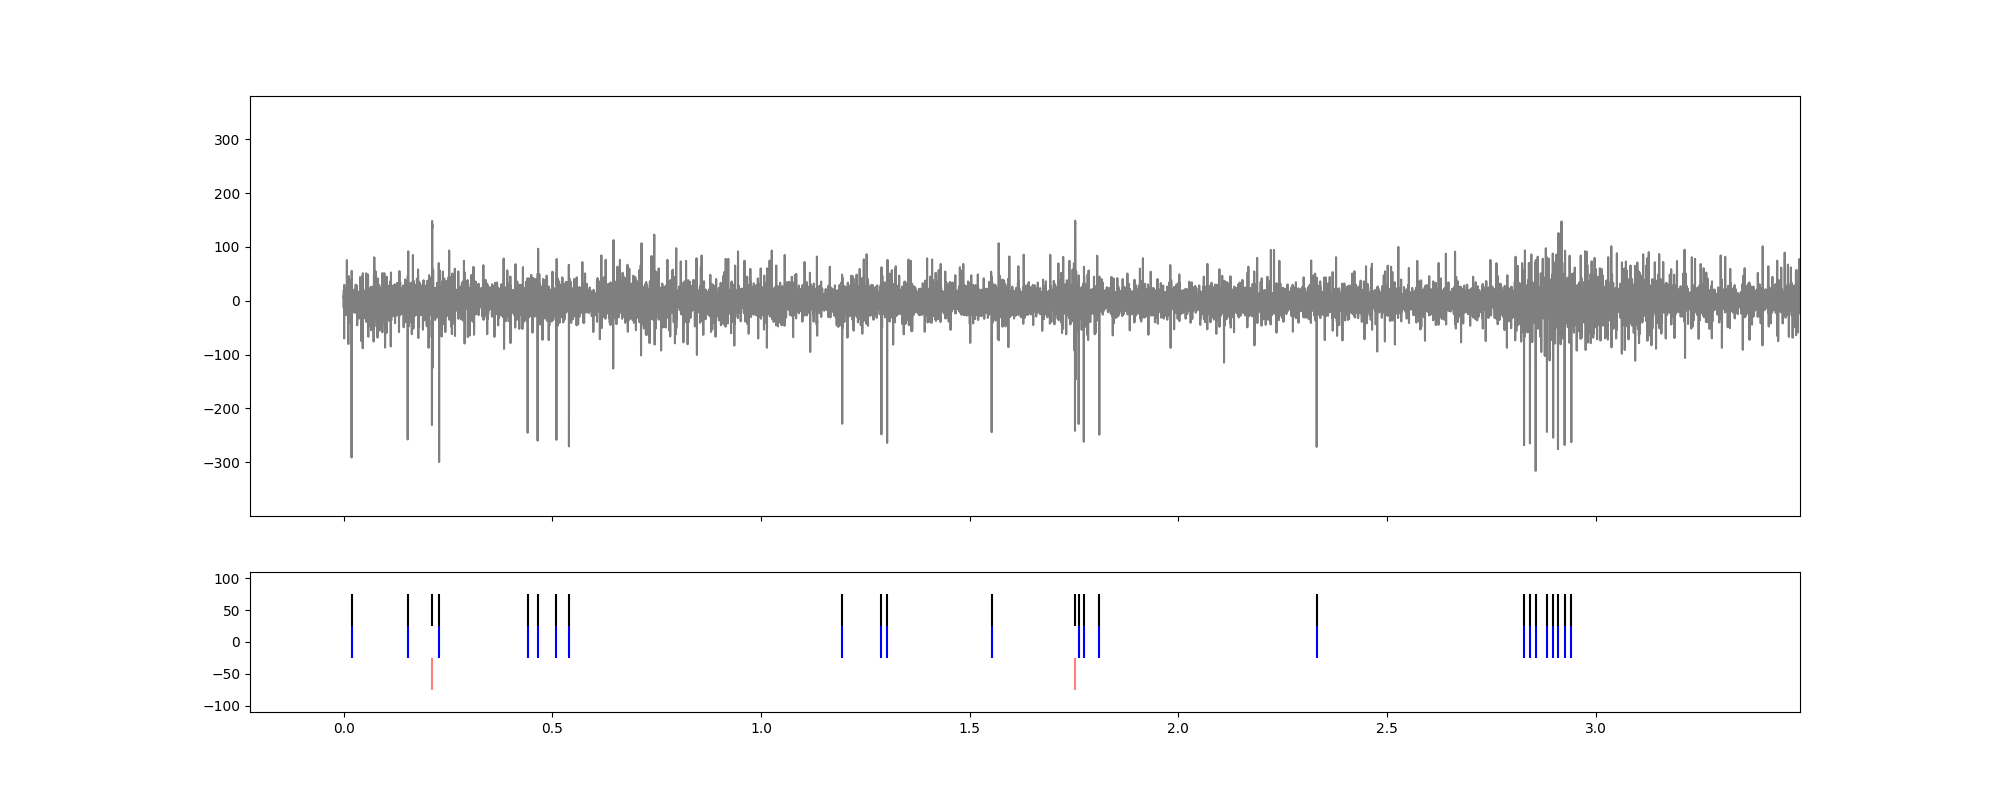

In [71]:
# plt.plot(chan_data_raw[chan_index,:], alpha = 0.5)

# plt.plot(chan_data[chan_index,:], alpha = 0.8)
# plt.subplot(212, sharex=ax1)
# plt.eventplot(cs_indices, linelengths=50, colors='r', alpha=0.5)
f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(20,8), sharex=True)

# prange = [css.signal_size*css.dt - 10, css.signal_size*css.dt] #s
prange = [0,10] #s
idx_voltage = [int(pr*Fs) for pr in prange]
# ax1 = plt.subplot(211)
ax0.plot(np.arange(prange[0],prange[1],1/Fs), css.voltage[idx_voltage[0]: idx_voltage[1]], alpha=0.5, color='k')
# plt.subplot(212)
ax1.eventplot(css.spike_indices[np.where(np.logical_and(css.spike_indices < idx_voltage[1] , css.spike_indices >= idx_voltage[0]))]*css.dt, linelengths=50, lineoffsets=50, color='k')
# ss_indices = css.get_spike_indices()
plt.eventplot(ss_indices[np.where(np.logical_and(ss_indices < idx_voltage[1]+ 1 , ss_indices >= idx_voltage[0]))]*css.dt, linelengths=50, lineoffsets=0, color='b')

# ax1.eventplot(css.cs_indices[np.where(np.logical_and(css.cs_indices < idx_voltage[1] , css.cs_indices >= idx_voltage[0]))]*css.dt, linelengths=50, lineoffsets=0, color='g')
ax1.eventplot(cs_indices[np.where(np.logical_and(cs_indices < idx_voltage[1] , cs_indices >= idx_voltage[0]))]*css.dt, linelengths=50, lineoffsets=-50, color='r', alpha = 0.5)
# ax1.eventplot(cs_indices_ehsan[np.where(np.logical_and(cs_indices_ehsan < idx_voltage[1] , cs_indices_ehsan >= idx_voltage[0]))]*css.dt, linelengths=50, lineoffsets=-100, color='m')



(50,)

In [44]:
def cs_xcorr(ss_times, cs_times, window=20):
    xcor_vect = np.zeros(2*(window) + 1)
    for csi in cs_indices:
        
        

SyntaxError: unexpected EOF while parsing (<ipython-input-44-a27ed00e1f24>, line 5)

In [47]:
SS = np.zeros(np.int64(css.signal_size/30.0))
SS[np.int64(ss_indices/30.0)] = 1
CS = np.zeros(np.int64(css.signal_size/30.0))
CS[np.int64(cs_indices/30.0)] = 1

<IPython.core.display.Javascript object>


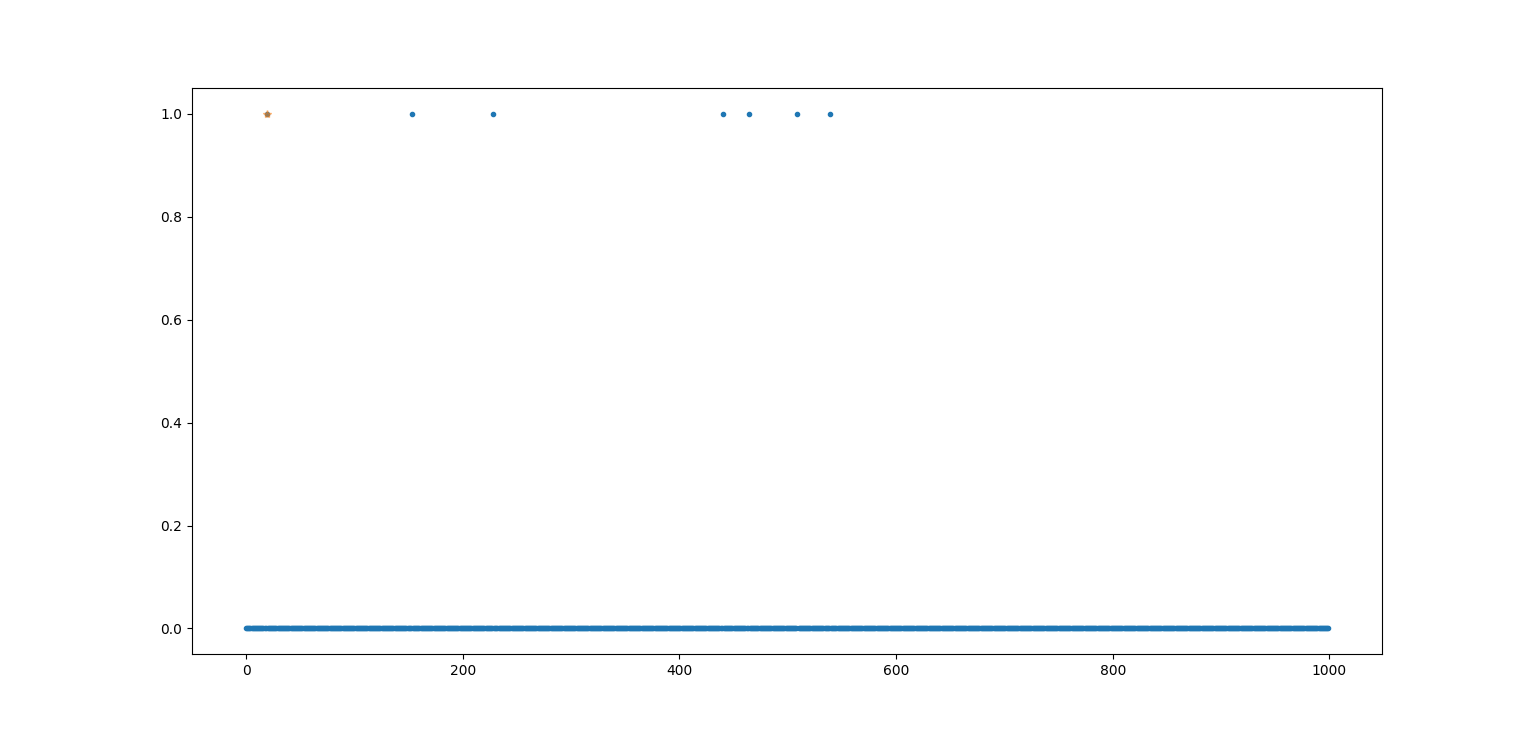

In [53]:
plt.figure()
plt.plot(SS[0:1000], '.')
plt.plot(ss_indices[0]/30,1, '*', alpha = 0.5)

In [45]:
ss_times = ss_indices/Fs
cs_times = cs_indices/Fs
window = 25
xcor_vect = np.zeros(2*window + 1)
# for cst in cs_indices:
cst = cs_indices[0]
np.where(np.logical_and(ss_times <= cst + window, ss_times >= cs))




In [ ]:
def cs_ss_corr(cs_indices, ss_indices, window, signal_size, Fs):
    SS = np.zeros(np.int64(css.signal_size/30.0))
    SS[np.int64(ss_indices/30.0)] = 1
    CS = np.zeros(np.int64(css.signal_size/30.0))
    CS[np.int64(cs_indices/30.0)] = 1
    xcor_vect = np.zeros((2*window + 1))
    for cti in np.int64(cs_indices/30.0):
        xcor_vect = xcor_vect + SS[cti-window : cti + window + 1]
    

In [97]:

window = 25
xcor_vect = np.zeros((2*window + 1))
for cti in np.int64(cs_indices/30.0):
    xcor_vect = xcor_vect + SS[cti-window : cti + window + 1]

In [103]:
window = 25
acor_vect = np.zeros((2*window + 1))
for sti in np.int64(ss_indices[1:-1]/30.0):
    acor_vect = acor_vect + SS[sti-window : sti + window + 1]

In [107]:
acor_vect[25] = 0

<IPython.core.display.Javascript object>


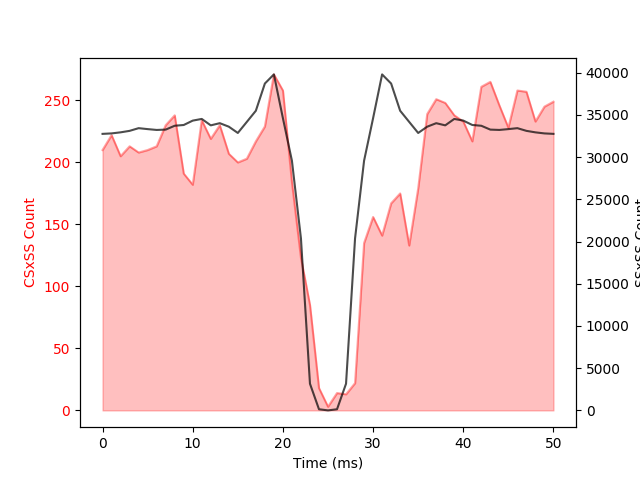

Text(0, 0.5, 'SSxSS Count')

In [117]:
plt.figure()
plt.plot(xcor_vect, 'r', alpha=0.35)
plt.yticks(color='r')
plt.fill_between(np.arange(0,2*window + 1), xcor_vect, color='r', alpha=0.25)
plt.ylabel('CSxSS Count', color = 'r')
plt.xlabel('Time (ms)')

plt.twinx()
plt.plot(acor_vect, 'k', alpha=0.70)
plt.yticks(color='k')
plt.ylabel('SSxSS Count', color='k')
# plt.fill_between(acor_ret[0], 0, acor_ret[1] , color='g', alpha=0.25)


<IPython.core.display.Javascript object>


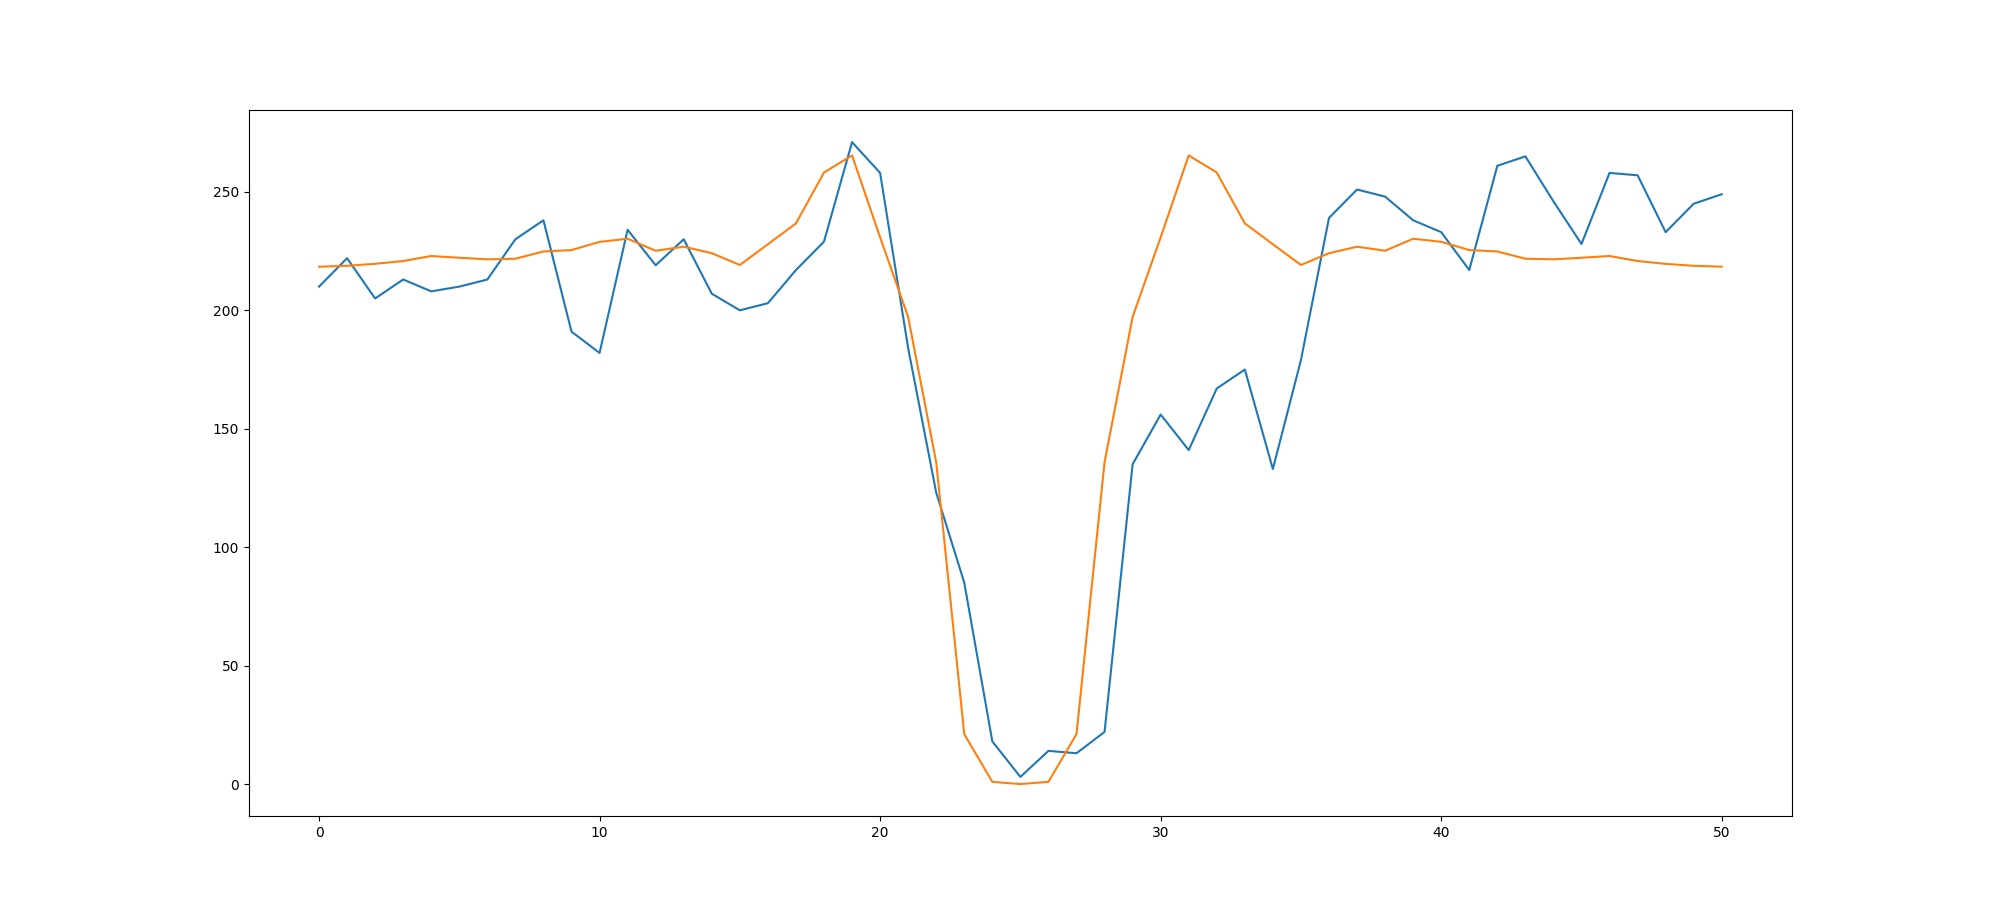

In [110]:
plt.figure()
plt.plot(xcor_vect)
plt.plot(acor_vect/150.0)